In [ ]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore,boxcox
import pandas as pd
import numpy as np
import re
import pickle
from collections import defaultdict
import seaborn as sb 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from category_encoders import TargetEncoder

In [295]:
# load dataset 
df = pd.read_csv("housing.csv")  
df.head()

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Road Type,Build Area,Posted,Amenities
0,Flat System House On Sale At Budhanikantha : H...,"Budhanikantha, Budhanilkantha, Kathmandu",Kathmandu,90000000,6,3,2.0,10,West,2073.0,17,1-0-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,18-0-0-0 Aana,11 hours ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,21 Aana Beautiful House : House For Sale In Bu...,"Pasikot, Budhanilkantha, Kathmandu",Kathmandu,80000000,5,3,2.0,9,East,2073.0,26,0-21-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-14-0-0 Aana,12 hours ago,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."
2,Beautiful To Floor House : House For Sale In D...,"Dhapasi, Dhapasi, Kathmandu",Kathmandu,70000000,5,3,2.0,12,East,2071.0,154,1-1-0-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,10-1-0-0 Aana,2 days ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
3,Modern Architecture Bungalow House : House For...,"baluwatar, Baluwatar, Kathmandu",Kathmandu,130000000,6,4,3.0,9,West,2017.0,17,0-10-1-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-7-1-0 Aana,1 day ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
4,Modern Bungalow House : House For Sale In Golf...,"Golfutar, Golfutar, Kathmandu",Kathmandu,100000000,6,3,2.0,10,East,2070.0,59,0-19-2-0 Aana,20 Feet / Blacktopped,20 Feet,Blacktopped,0-14-2-0 Aana,2 days ago,"['Parking', 'Lawn', 'Garage', 'Balcony', 'Back..."


In [296]:
# converting area and build area to suitable numeric formats 
ROPANI_TO_SQFT = 5476
AANA_TO_SQFT = 342.25
PAISA_TO_SQFT = 85.56
DAAM_TO_SQFT = 21.39

def parse_area(area_str):
    if pd.isna(area_str) or not isinstance(area_str, str):
        return np.nan

    area_str = area_str.strip()

    match = re.match(r"(\d+)-(\d+)-(\d+)-(\d+)", area_str)
    if match:
        r, a, p, d = map(int, match.groups())
        return (r * ROPANI_TO_SQFT) + (a * AANA_TO_SQFT) + (p * PAISA_TO_SQFT) + (d * DAAM_TO_SQFT)

    num_parts = re.split(r'[-\.]', area_str)
    num_parts = [int(x) for x in num_parts if x.isdigit()]

    if "ropani" in area_str.lower():
        return num_parts[0] * ROPANI_TO_SQFT if num_parts else np.nan
    if "aana" in area_str.lower():
        return num_parts[0] * AANA_TO_SQFT if num_parts else np.nan
    if "paisa" in area_str.lower():
        return num_parts[0] * PAISA_TO_SQFT if num_parts else np.nan
    if "daam" in area_str.lower():
        return num_parts[0] * DAAM_TO_SQFT if num_parts else np.nan

    for x in num_parts:
        return x  
    return np.nan
for col in ['Area', 'Build Area']:
    if col in df.columns:
        df[col] = df[col].apply(parse_area)

In [297]:
# cleansing road_width column 
def extract_feet(val):
    if pd.isna(val):
        return np.nan
    num = re.findall(r"[\d\.]+", str(val))
    return float(num[0]) if num else np.nan

if 'Road Width(in feet)' in df.columns:
    df['Road Width(in feet)'] = df['Road Width(in feet)'].apply(extract_feet)
df.head()

,Title,Address,City,Price,Bedroom,Bathroom,Floors,Parking,Face,Year,Views,Area,Road,Road Width,Road Type,Build Area,Posted,Amenities
0,Flat System House On Sale At Budhanikantha : H...,"Budhanikantha, Budhanilkantha, Kathmandu",Kathmandu,90000000,6,3,2.0,10,West,2073.0,17,5476.00,20 Feet / Blacktopped,20 Feet,Blacktopped,98568.00,11 hours ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
1,21 Aana Beautiful House : House For Sale In Bu...,"Pasikot, Budhanilkantha, Kathmandu",Kathmandu,80000000,5,3,2.0,9,East,2073.0,26,7187.25,20 Feet / Blacktopped,20 Feet,Blacktopped,4791.50,12 hours ago,"['Parking', 'Garage', 'Fencing', 'Frontyard', ..."
2,Beautiful To Floor House : House For Sale In D...,"Dhapasi, Dhapasi, Kathmandu",Kathmandu,70000000,5,3,2.0,12,East,2071.0,154,5818.25,20 Feet / Blacktopped,20 Feet,Blacktopped,55102.25,2 days ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
3,Modern Architecture Bungalow House : House For...,"baluwatar, Baluwatar, Kathmandu",Kathmandu,130000000,6,4,3.0,9,West,2017.0,17,3508.06,20 Feet / Blacktopped,20 Feet,Blacktopped,2481.31,1 day ago,"['Parking', 'Lawn', 'Garage', 'Frontyard', 'Fe..."
4,Modern Bungalow House : House For Sale In Golf...,"Golfutar, Golfutar, Kathmandu",Kathmandu,100000000,6,3,2.0,10,East,2070.0,59,6673.87,20 Feet / Blacktopped,20 Feet,Blacktopped,4962.62,2 days ago,"['Parking', 'Lawn', 'Garage', 'Balcony', 'Back..."


In [298]:
# initial cleanup
drop_cols = [c for c in ['Title','Views','Posted','Road','Amenities'] if c in df.columns]
if drop_cols:
    df = df.drop(drop_cols, axis=1)
# cleanup strings 
def clean_text_col(s):
    return s.astype(str).str.strip().str.lower().str.title()

In [299]:
# autodectect if some doesnt exist 
possible_high_card = ['Address1','Address2','City']
possible_normal_cat = ['Face','Road Type','Parking']
numerical_cols = ['Bedroom','Bathroom','Floors','Road Width(in feet)','Age','Area_sqft','Build_Area_sqft']
# intersecting with actual df columns 
numerical_cols = [c for c in numerical_cols if c in df.columns]
high_card_cat_cols = [c for c in possible_high_card if c in df.columns]
normal_cat_cols = [c for c in possible_normal_cat if c in df.columns]
# applying basic string cleaning for categorical columns 
for col in high_card_cat_cols + normal_cat_cols:
    df[col] = clean_text_col(df[col])

In [302]:
# checking for outliers in numerical columns 
outlier_summary = {} 
for col in numerical_cols:
    if col in df.columns:
        col_data = df[col].dropna()
        col_zscore = zscore(col_data)
        outliers = col_data[(col_zscore > 3) | (col_zscore < -3)]
        
        outlier_summary[col] = {
            'num_outliers': len(outliers),
            'outlier_values': outliers.tolist()
        }
for col, info in outlier_summary.items():
    print(f"{col}: {info['num_outliers']} outliers")

Bedroom: 25 outliers
Bathroom: 21 outliers
Floors: 15 outliers


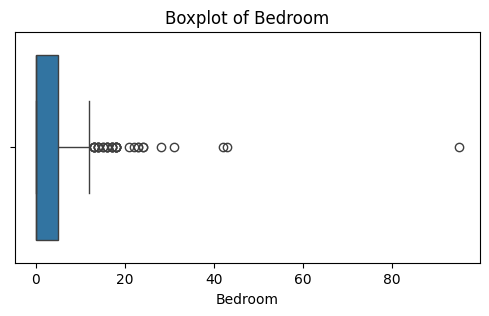

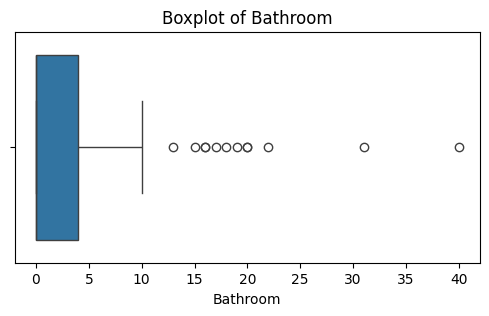

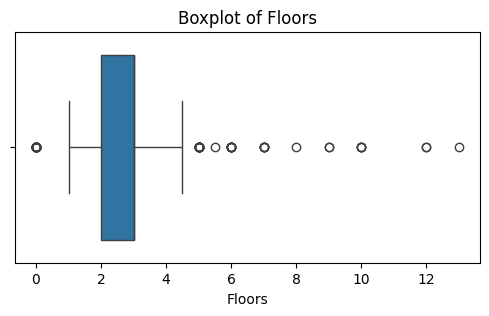

In [303]:
# visualizing outliers using boxplots
for col in numerical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sb.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

In [304]:
q_low = df['Price'].quantile(0.25)
q_high = df['Price'].quantile(0.75)
df = df[(df['Price'] > q_low) & (df['Price'] < q_high)]

In [305]:
# preparing training testing splits 
if 'Price' not in df.columns:
    raise RuntimeError("Dataset must have 'Price' column")
# preparing input features and target 
X = df.drop(columns=['Price'])
y = np.log1p(df['Price'])
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (870, 14) X_test shape: (218, 14)


In [306]:
# target encoders for high cardinality features 
target_encoders = {}
for col in high_card_cat_cols:
    te = TargetEncoder()
    X_train[col] = te.fit_transform(X_train[col], y_train)
    X_test[col] = te.transform(X_test[col])
    target_encoders[col] = te
print("Target encoders for:", list(target_encoders.keys()))

Target encoders for: ['City', 'Address1', 'Address2']


In [307]:
# setting up preprocessing pipeline
num_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

cat_low_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_cols),
    ('cat_low', cat_low_transformer, normal_cat_cols)
], remainder='drop') 

In [308]:
# setting up models grid
models =  {
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {
            'model__max_depth': [None, 5, 10, 15, 20],
            'model__min_samples_leaf': [1, 2, 5, 10],
        }
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            'model__n_estimators': [100, 200, 400],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [1, 2, 5],
        }
    ),
    "XGBRegressor": (
        XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        {
            'model__n_estimators': [200, 400, 800],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.8, 1.0],
            'model__colsample_bytree': [0.7, 0.8, 1.0]
        }
    )
}
# getting into hyperparameter tuning
best_models = {}
results = []

for name, (estimator, param_dist) in models.items():
    print(f"\n--- Tuning {name} ---")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=20,            
        cv=3,
        scoring='r2',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
rs.fit(X_train, y_train)


--- Tuning DecisionTree ---

--- Tuning RandomForest ---

--- Tuning XGBRegressor ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Bedroom',
                                                                                'Bathroom',
                                                                                'Floors']),
                                                                              ('cat_low',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Face',
                                                                                'Road '
                                                                                '...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    1.0],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [200, 400, 800],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [310]:
# evaluation of best models 
best = rs.best_estimator_
y_pred = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"{name} -> Test RMSE: {rmse:.2f}, Test R2: {r2:.4f}")

best_models[name] = {
        'estimator': best,
        'cv_best_score': rs.best_score_,
        'test_rmse': rmse,
        'test_r2': r2,
        'best_params': rs.best_params_
    }
results.append((name, r2, rmse, rs.best_params_))

# choosing best model by R2 score
best_by_r2 = max(results, key=lambda x: x[1])
best_name = best_by_r2[0]
best_model_obj = best_models[best_name]['estimator']
print("\nBest model:", best_name, "Test R2:", best_by_r2[1])
print("Best model parameters:", best_by_r2[3])


XGBRegressor -> Test RMSE: 0.61, Test R2: 0.5872

Best model: XGBRegressor Test R2: 0.5872092697305694
Best model parameters: {'model__subsample': 0.7, 'model__n_estimators': 800, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}


In [ ]:
num_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numerical_cols),
    ('cat', cat_transformer, normal_cat_cols)
], remainder='drop')

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(
        **best_models['XGBRegressor']['best_params']
    ))
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred) 
print(f"Final Model -> Test RMSE: {rmse:.2f}, Test R2: {r2:.4f}")

Final Model -> Test RMSE: 0.65, Test R2: 0.5362


In [ ]:

with open("final_model.pkl", "wb") as f:
    pickle.dump(model_pipeline, f)
print("Model pipeline saved to 'final_model.pkl'")

Model pipeline saved to 'final_model.pkl'
